In [1]:
# improves quality of graphic outputs if you're on a Macbook with Retina display
%config InlineBackend.figure_format = 'retina'

# can display multiple things without call to print()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# interactive plots
# %matplotlib notebook
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import utils

/Users/Jake/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
train = pd.read_csv('data/train.csv', index_col='ID')
y = train['y']
train.drop('y', axis=1, inplace=True)
test = pd.read_csv('data/test.csv', index_col='ID')
constcols_train = list(train.loc[:,train.apply(lambda i: len(i.unique()) == 1)].columns)
goodcols = list(set(train.columns).intersection(set(test.columns)) - set(constcols_train))
train = train[goodcols]
test = test[goodcols]
tot = pd.concat([train, test]).sort_index()
enumcols = list(tot.select_dtypes(include=['object']).columns)
bincols = list(tot.select_dtypes(include=['int64']).columns)

In [8]:
totOHE = pd.get_dummies(tot, columns=enumcols)
trainOHE = totOHE.loc[train.index]
testOHE = totOHE.loc[test.index]

In [13]:
from statsmodels.tsa.stattools import adfuller
tmp = train.loc[train['y']<train['y'].max(),'y']
print('WITH OUTLIER \n ADF Statistic: {r[0]}, p-val: {r[1]}'.format(r=adfuller(tmp)))
tmp.agg(['mean','std','skew','kurt'])
sm.OLS(tmp, sm.add_constant(tmp.index)).fit().summary()

tmp2 = tmp.pct_change().dropna()
print('WITHOUT OUTLIER \n ADF Statistic: {r[0]}, p-val: {r[1]}'.format(r=adfuller(tmp2)))
tmp2.agg(['mean','std','skew','kurt'])
sm.OLS(tmp2, sm.add_constant(tmp2.index)).fit().summary()

del tmp, tmp2

WITH OUTLIER 
 ADF Statistic: -44.8751711040339, p-val: 0.0


mean    100.630190
std      12.424146
skew      0.738671
kurt      1.505205
Name: y, dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     11.89
Date:                Wed, 31 May 2017   Prob (F-statistic):           0.000568
Time:                        23:46:14   Log-Likelihood:                -16567.
No. Observations:                4208   AIC:                         3.314e+04
Df Residuals:                    4206   BIC:                         3.315e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        101.7688      0.382    266.733      0.000     101.021     102.517
x1            -0.0003   7.85e-05     -3.449      0.001      -0.000      -0.000
==============================================================================
Omnibus:                      446.373   Durbin-Watson:                   2.194
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              765.206
Skew:                           0.734   Prob(JB):                    6.88e-167
Kurtosis:                       4.486   Cond. No.                     9.70e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

WITHOUT OUTLIER 
 ADF Statistic: -19.452668872736226, p-val: 0.0


mean    0.016098
std     0.183344
skew    0.559753
kurt    0.792236
Name: y, dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1012
Date:                Wed, 31 May 2017   Prob (F-statistic):              0.750
Time:                        23:46:14   Log-Likelihood:                 1167.8
No. Observations:                4207   AIC:                            -2332.
Df Residuals:                    4205   BIC:                            -2319.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0177      0.006      3.129      0.002       0.007       0.029
x1          -3.69e-07   1.16e-06     -0.318      0.750   -2.64e-06    1.91e-06
==============================================================================
Omnibus:                      251.061   Durbin-Watson:                   3.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              327.691
Skew:                           0.559   Prob(JB):                     6.96e-72
Kurtosis:                       3.788   Cond. No.                     9.70e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [104]:
one = pd.DataFrame.from_dict({c: train.loc[train[c].loc[lambda x: x==1].index,'y'].agg(['mean','std','skew','kurt']) for c in bincols}, orient='index').sort_index()
one.dropna(inplace=True)
one['yval'] = 'one'
zero = pd.DataFrame.from_dict({c: train.loc[train[c].loc[lambda x: x==0].index,'y'].agg(['mean','std','skew','kurt']) for c in bincols}, orient='index').sort_index()
zero.dropna(inplace=True)
zero['yval'] = 'zero'


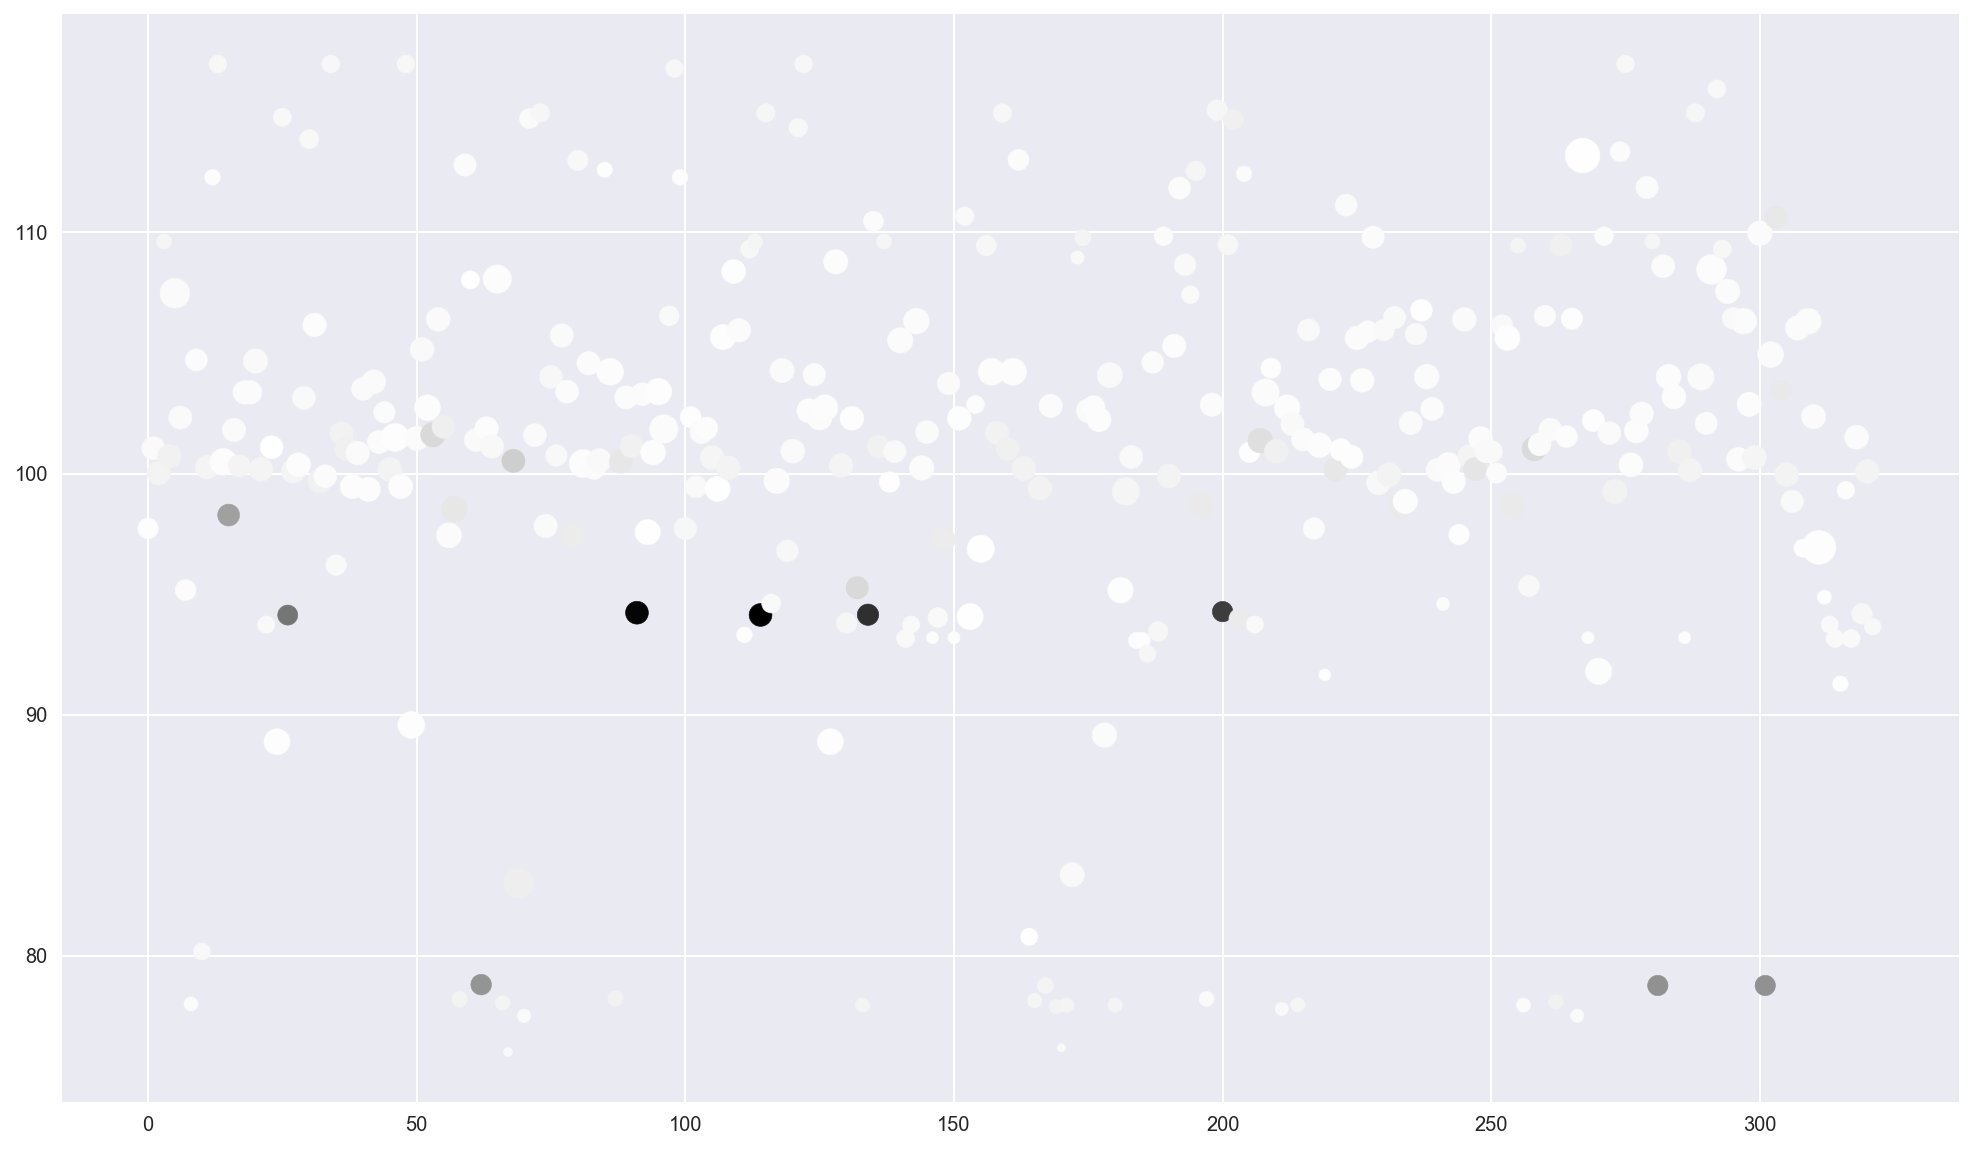

In [143]:
plt.figure(figsize=(17,10))
plt.scatter(x=np.arange(len(one)), y=one['mean'], c=one['kurt'], s=300*one['std']/one['std'].max())
# plt.xticks(np.arange(len(one)), list(one.index), rotation='vertical')
plt.show();
# tmp.loc[tmp.isnull().any(axis=1),:].head()
# train.loc[train['X190']==1,'y'].value_counts()
# sns.pairplot(pd.concat([one, zero]), hue='yval')

In [6]:
np.unique(trainOHE.values)

array([0, 1])

In [25]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

RS = 42

x1, x2, y1, y2 = train_test_split(trainOHE, y, test_size=0.2, random_state=RS)

clfs = {
    'RFR': [RandomForestRegressor(random_state=RS), {
        'n_estimators': [10, 100, 1000],
        'min_samples_split': [2, 20, 200],
    }],
    'ABR': [AdaBoostRegressor(random_state=RS), {
        'n_estimators': [5, 50, 500],
        'learning_rate': [0.1, 0.5, 1.],
    }],
    'GBR': [GradientBoostingRegressor(random_state=RS), {
        'loss': ['ls', 'lad', 'huber', 'quantile'],
        'n_estimators': [10, 100, 1000],
        'learning_rate': [0.1, 0.5, 1.],
    }],
    'MLP': [MLPRegressor(random_state=RS), {
        'hidden_layer_sizes': [(5,5,2), (350, 250, 100)]
    }]
}

In [26]:
results = {name: utils.classify(params,x1=x1,y1=y1,x2=x2,y2=y2) for (name, params) in clfs.items()}

/Users/Jake/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/Jake/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/Jake/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


array([  77.82838235,   94.26569782,   77.82838235, ...,   94.26569782,
        112.82778119,   94.26569782])

In [9]:
%time svr1 = SVR(kernel='linear').fit(x1, y1)
%time svr2 = LinearSVR(random_state=RS).fit(x1, y1)
pred1 = svr1.predict(x2)
pred2 = svr2.predict(x2)
r2_score(y2, pred1)
r2_score(y2, pred2)

CPU times: user 6.19 s, sys: 65.3 ms, total: 6.26 s
Wall time: 6.29 s
CPU times: user 116 ms, sys: 8.64 ms, total: 124 ms
Wall time: 125 ms


0.55676837895382736

0.55612054023764634

In [12]:
from sklearn.model_selection import GridSearchCV
%time clf = GridSearchCV(SVR(kernel='linear'), {}).fit(x1, y1)

Using TensorFlow backend.


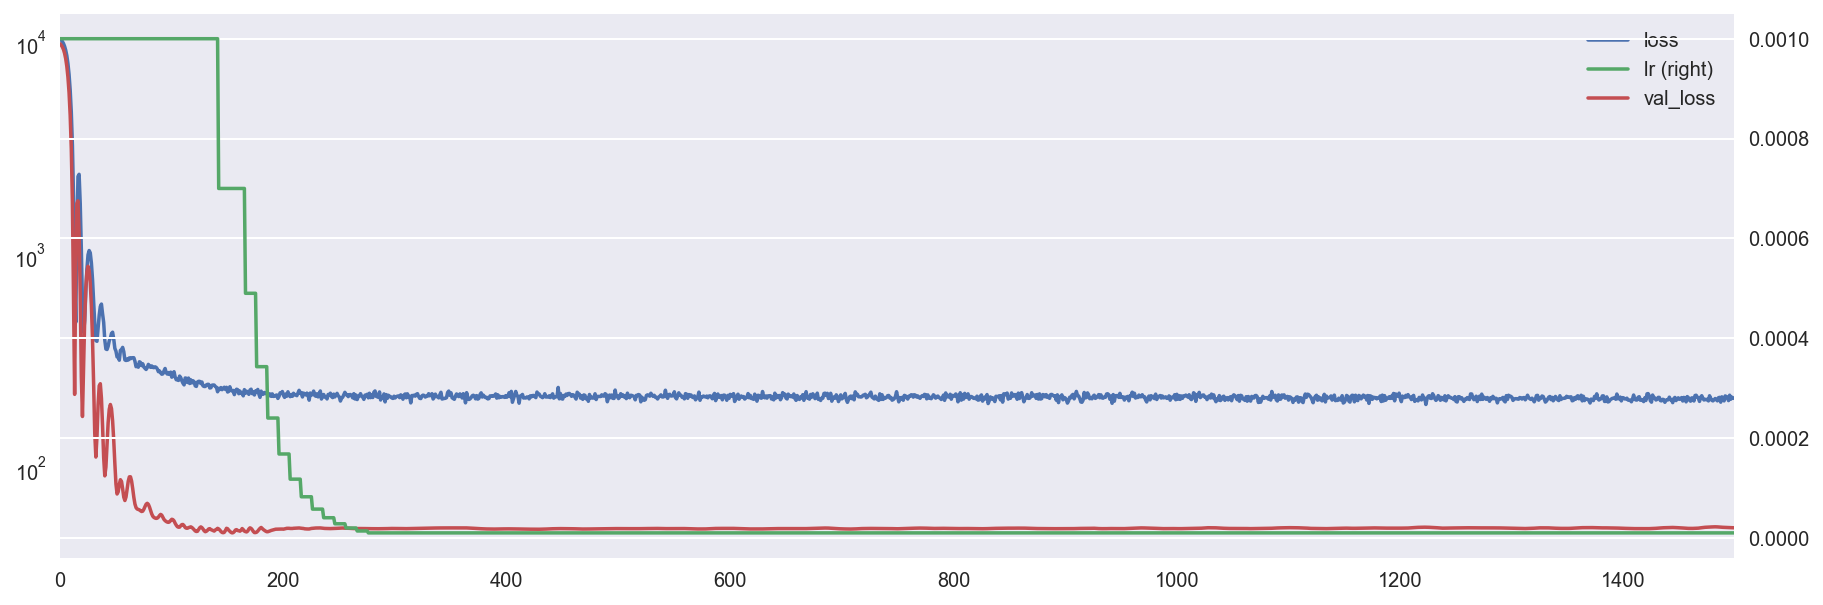

In [13]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, PReLU, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import regularizers
# from keras import metrics

def rshp(arr):
    return arr.reshape(*arr.shape, 1)

BATCHES = 6000
x = trainOHE.values

model = Sequential([
    Dense(x.shape[1], input_shape=(x.shape[1],), kernel_initializer='normal'),
    PReLU(),
    Dropout(0.5),
    Dense(int((x.shape[1]+1)/2), kernel_initializer='normal'),
    PReLU(),
    Dropout(0.5),
    Dense(int((x.shape[1]+1)/2), kernel_initializer='normal'),
    PReLU(),
    Dropout(0.5),
    Dense(1, kernel_initializer='normal'),
])

model.compile(optimizer='adam',
              loss='mse',
#               metrics=['mse'],
             )

h = model.fit(x, y, epochs=1500, batch_size=BATCHES,
          shuffle=True, validation_split=.2,
          verbose=0, callbacks=[
              ReduceLROnPlateau(patience=10, min_lr=0.00001, factor=0.7, cooldown=0),
#               EarlyStopping(monitor='val_loss', min_delta=-.1, patience=5)
          ])

pd.DataFrame(h.history).plot(secondary_y='lr', figsize=(15,5), logy=True, grid=False);
plt.show();

(array([  2.,   5.,  10.,   6.,   6.,  13.,  15.,  17.,  16.,  10.]),
 array([ 0.46594264,  0.48562839,  0.50531414,  0.52499989,  0.54468564,
         0.56437139,  0.58405714,  0.60374289,  0.62342864,  0.64311439,
         0.66280014]),
 <a list of 10 Patch objects>)

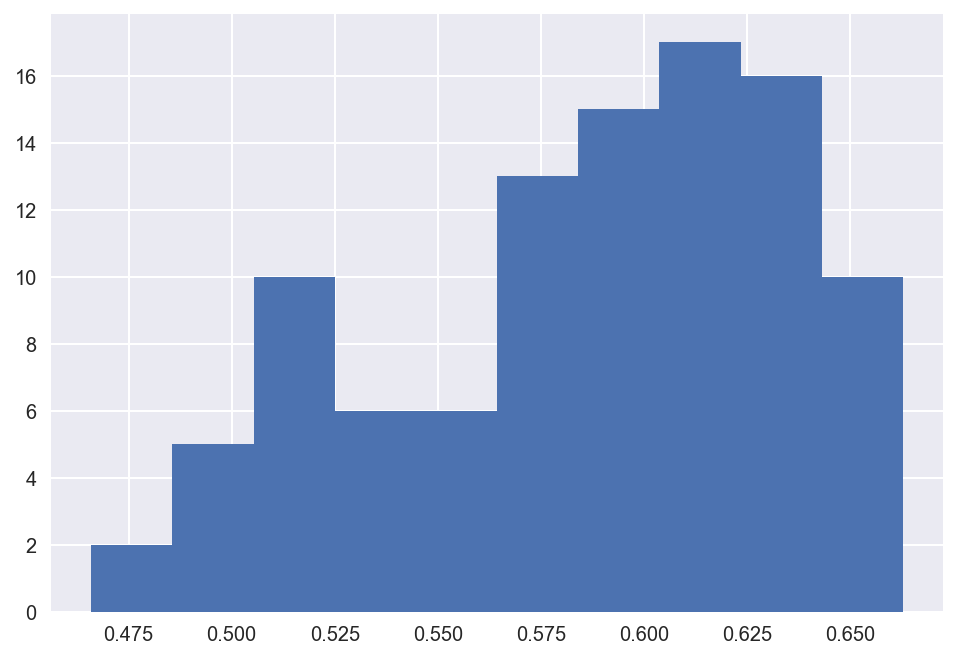

In [16]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score
tmp = []
for i in range(100):
    x1, x2, y1, y2 = train_test_split(trainOHE, y, test_size=0.2)
    x1, x2, y1, y2 = x1.values, x2.values, y1.values, y2.values
    tmp.append(r2_score(y2, model.predict(x2)))
plt.hist(tmp)

In [51]:
d = []
x = len(trainOHE.values)-4200
for i1 in range(x):
    for i2 in range(i1+1,x):
        d.append(np.dot(trainOHE.values[i1],trainOHE.values[i2]))

In [56]:
np.dot(trainOHE.iloc[0],trainOHE.iloc[0])

17171.256100000002

In [37]:
pd.DataFrame(index=testOHE.index, data=results['ABR']['best_classifier'].predict(testOHE), columns=['y']).to_csv('submission2.csv')

In [43]:
model.save('keras_model1')